## Group No **160**

## Group Member Names:
1. **Sushil Kumar 2023AA05849**
2. **Hemant Kumar Parakh 2023AA05741**
3. **Nagineni Sathish Babu 2023AA05585**
4. **Madala Akhil 2023AA05005**


In [ ]:
# !pip install opencv-python opencv-contrib-python
# !pip install tensorflow
# !pip install pandas
# !pip install matplotlib
# !pip install numpy


## 1. Import the required libraries

In [ ]:
import os,cv2
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2.ximgproc

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications.vgg16 import VGG16

## 2. Data Acquisition

**Dataset URL**: https://github.com/datitran/raccoon_dataset/tree/master

In [ ]:

df = pd.read_csv("E:/raccoon_dataset/data/train_labels.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-19.jpg,259,194,raccoon,87,8,182,89
3,raccoon-20.jpg,720,540,raccoon,2,29,720,503
4,raccoon-1.jpg,650,417,raccoon,81,88,522,408


In [ ]:
path = "E:/raccoon_dataset/images"

raccoon-17.jpg


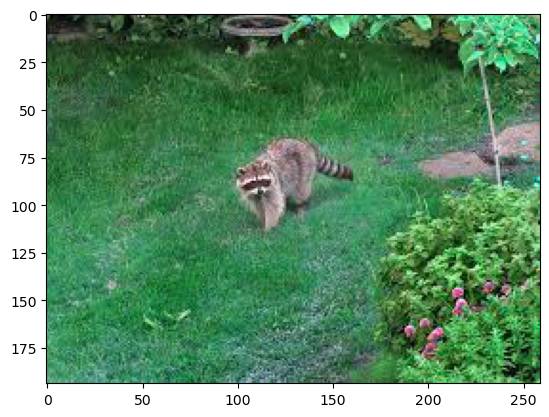

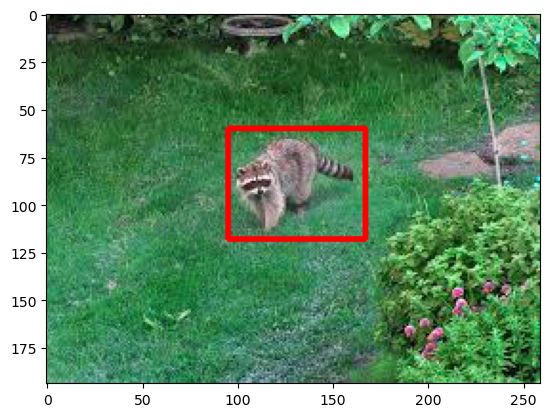

In [ ]:
for i in np.arange(df.shape[0]):
    filename = df["filename"][i].split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    plt.imshow(img)
    x1 = int(df["xmin"][i])
    y1 = int(df["ymin"][i])
    x2 = int(df["xmax"][i])
    y2 = int(df["ymax"][i])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

## 3. Data Preparation

The dataset involves loading images from the specified path and using OpenCV to preprocess the images

Image augmentation techniques like horizontal flip, vertical flip, and rotation are applied via ImageDataGenerator

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

[[ 33 512  63  61]
 [508 409  12  20]
 [368 336 164   6]
 ...
 [192 240 608 333]
 [ 96   0 704 345]
 [ 96   0 704 191]]


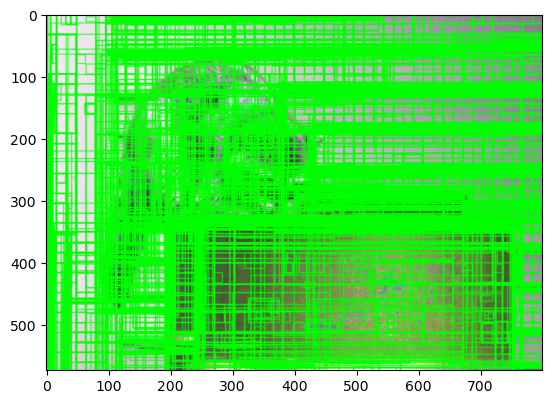

In [ ]:
im = cv2.imread(os.path.join(path,"raccoon-2.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(rects)
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
# creating the regional proposal for images
for i in np.arange(df.shape[0]):
    try:
        filename = df["filename"][i].split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        gtvalues=[]
        x1 = int(df["xmin"][i])
        y1 = int(df["ymin"][i])
        x2 = int(df["xmax"][i])
        y2 = int(df["ymax"][i])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e, result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

raccoon-17.jpg
raccoon-11.jpg
raccoon-19.jpg
raccoon-20.jpg
raccoon-1.jpg
raccoon-4.jpg
raccoon-10.jpg
raccoon-9.jpg
raccoon-12.jpg
raccoon-12.jpg
raccoon-16.jpg
raccoon-21.jpg
raccoon-3.jpg
raccoon-2.jpg
raccoon-18.jpg
raccoon-24.jpg
raccoon-24.jpg
raccoon-15.jpg
raccoon-6.jpg
raccoon-7.jpg
raccoon-13.jpg
raccoon-23.jpg
raccoon-22.jpg


In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
X_new.shape

(829, 224, 224, 3)

## 4. DNN Architecture

The model is based on VGG16, pre-trained on the ImageNet dataset

A new dense layer is added on top of the VGG16 architecture

**Number of Layers and Justification**:
*   The VGG16 model is pre-trained, and layers up to the 15th are frozen
*   This strategy of freezing layers is commonly used to preserve the learned features of lower layers in transfer learning, which helps to speed up training and avoid overfitting.

**Number of Units in Each Layer and Justification**:
*   The final layer added to the model has 2 units with a softmax activation function
*   This is suitable for a binary classification problem, which matches the dataset's nature.

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

## 5. Training the model
*   The model is compiled with categorical cross-entropy as the loss function and Adam optimizer
*   Training and testing datasets are created using ImageDataGenerator for data augmentation
*   The model is trained using a training dataset generator (traindata) with 5 epochs and validation on a test dataset (testdata)

In [ ]:
model_final = Model(vggmodel.input, predictions)

In [ ]:
opt = Adam(learning_rate=0.0001)

In [ ]:
model_final.compile(loss = categorical_crossentropy, optimizer = opt, metrics=["acc"])

In [ ]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 126,633,474 (483.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(746, 224, 224, 3) (83, 224, 224, 3) (746, 2) (83, 2)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
#hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])
#hist = model_final.fit(X_new, Y, epochs= 10, validation_split=0.1, callbacks=[checkpoint,early])
hist = model_final.fit(x=traindata, epochs=5, validation_data=testdata, callbacks=[checkpoint, early])
#hist = model_final.fit(x=traindata, epochs=2, validation_data=testdata, callbacks=[checkpoint, early])


Epoch 1/5


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - acc: 0.8440 - loss: 0.5141 
Epoch 1: val_loss improved from inf to 0.02157, saving model to ieeercnn_vgg16_1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 677s 28s/step - acc: 0.8474 - loss: 0.5046 - val_acc: 0.9880 - val_loss: 0.0216
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - acc: 0.9852 - loss: 0.0529 
Epoch 2: val_loss improved from 0.02157 to 0.02060, saving model to ieeercnn_vgg16_1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 477s 19s/step - acc: 0.9851 - loss: 0.0529 - val_acc: 0.9880 - val_loss: 0.0206
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.9834 - loss: 0.0550 
Epoch 3: val_loss improved from 0.02060 to 0.00238, saving model to ieeercnn_vgg16_1.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 295s 12s/step - acc: 0.9836 - loss: 0.0544 - val_acc: 1.0000 - val_loss: 0.0024
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - acc: 0.9947 - loss: 0.0094 
Epoch 4: val_loss did not improve from 0.00238
24/24 ━━━━━━━━━━━━━━━━━━━━ 275s 11s/step - acc: 0.9948 - 

## 6. Test the model

**Making Predictions on Test Data**: A sample from the test dataset is loaded and passed to the model for prediction

**Selective Search Testing on Test Images**: Bounding boxes are drawn on the test images, and the model predicts whether the objects detected are within a specific class


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
not plane


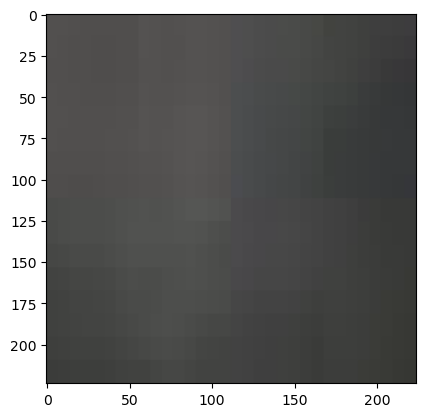

In [ ]:
im = X_test[80]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [ ]:
test_df = pd.read_csv("E:/raccoon_dataset/data/test_labels.csv")
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-8.jpg,259,194,raccoon,16,11,236,175
1,raccoon-134.jpg,225,225,raccoon,125,87,194,169
2,raccoon-144.jpg,570,390,raccoon,117,42,387,390
3,raccoon-129.jpg,639,315,raccoon,142,24,442,276
4,raccoon-128.jpg,259,194,raccoon,76,87,190,148


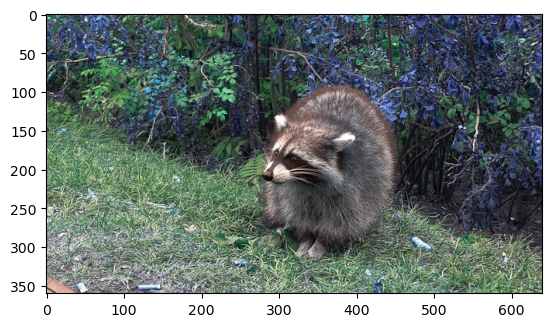

In [ ]:
plt.figure()
plt.imshow(imout)

## 7. Report the result

**Plotting the Loss and Validation Loss**: The model’s performance is visualized using a loss vs. validation loss plot

**Visual Results from Model Predictions**: The notebook visually shows the prediction results by displaying bounding boxes on images after the model makes predictions

Shown the Confusion Matrix for testing dataset.

Calculated the values for performance study metrics like accuracy, precision, recall, F1 Score.

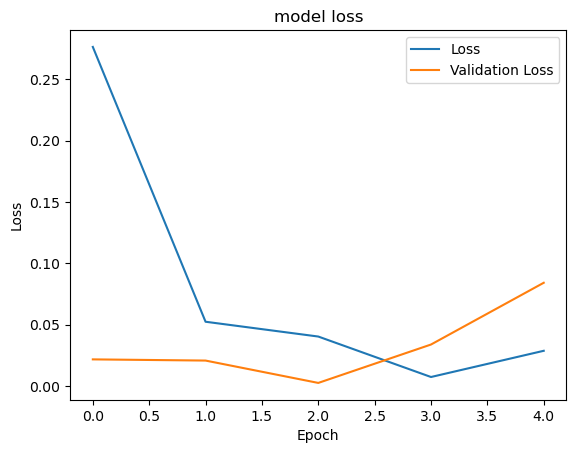

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

raccoon-8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━

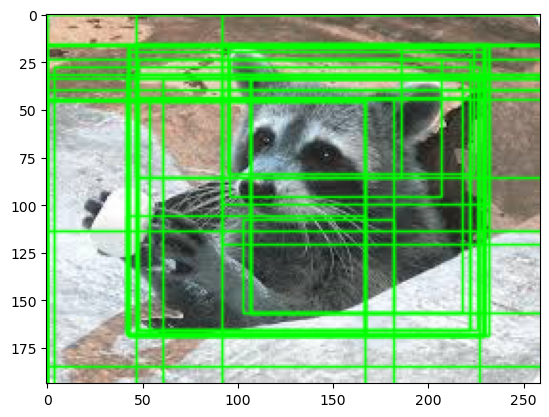

In [ ]:
for i in np.arange(test_df.shape[0]):
    filename = test_df["filename"][i].split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    #plt.imshow(img)
    for e,result in enumerate(ssresults):
        if e < 1000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            if out[0][0] > 0.90:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)
    break

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have your trained model as `model_final`
# 1. Get the predicted values from the model
y_pred_prob = model_final.predict(X_test)  # X_test is your test input
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# 2. Assuming y_test contains true labels in a categorical format
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to labels if necessary

# 3. Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 4. Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 5. Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# 6. Calculate Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# 7. Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step
Confusion Matrix:
[[10  0]
 [ 2 71]]
Accuracy: 0.9759
Precision: 0.9799
Recall: 0.9759
F1 Score: 0.9768


***Conclusion***:

The model performs exceptionally well:

Confusion Matrix: 10 true negatives, 0 false positives, 71 true positives, and 2 false negatives.

Accuracy: 97.59%, indicating robust overall performance.

Precision: 97.99%, reflecting the model's reliability in making positive predictions.

Recall: 97.59%, confirming the model’s effectiveness in identifying positive cases.

F1 Score: 97.68%, demonstrating a solid balance between precision and recall.

Overall, the model is highly accurate and reliable, with minimal errors in classification.